# 1. RNN

- 시계열 데이터를 다루기 위한 모형
- 단어의 순서를 통해 형성되는 문맥을 파악하기에 좋은 모형

# 2. Word Embedding

- 범주형 데이터를 연속적인 값을 갖는, 상대적으로 작은 크기의 벡터로 변환하는 작업
- 보통 단어에 대해 One-hot encoding을 먼저 수행하고, 이를 다시 연속형 값을 갖는 축소된 벡터로 변환하는 과정을 의미
- 희소 벡터 -> 밀집 벡터

## Embedding의 이유

- 차원이 큰 원핫 벡터를 그대로 쓰면 연산이 비효율적임
- 대상 간의 의미적 유사도 계산 가능
- 단어가 의미적인 정보를 함축함으로써 연산이 가능해짐
- 전이 학습이 가능

# 3. RNN - 감성분석

- 감성분석은 긍정과 부정 중 하나를 선택하는 이진 분류 문제
- 신경망의 최종 출력단 크기 1, 활성화 함수는 시그모이드
- 손실 함수 : binary_crossentropy

In [3]:
from nltk.corpus import movie_reviews

fileids = movie_reviews.fileids()
reviews = [movie_reviews.raw(fileid) for fileid in fileids]
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))

Reviews count: 2000
Length of the first review: 4043
Labels: {'pos', 'neg'}


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

np.random.seed(7)
tf.random.set_seed(7)

- fit_on_texts() : 주어진 말뭉치에 대해 단어 인덱스 사전 구축
- texts_to_seqeunces() : 해당 사전을 이용해 문서들을 인덱스의 시퀀스로 변환
- oov_token : 사전에 없는 단어들이 생략되는 대신 공통의 값으로 변환

In [5]:
max_words = 10000
tokenizer = Tokenizer(num_words = max_words, oov_token = 'UNK')

tokenizer.fit_on_texts(reviews)

X = tokenizer.texts_to_sequences(reviews)

print('Lengths of first 10 documents: ', [len(doc) for doc in X[:10]])

Lengths of first 10 documents:  [710, 240, 486, 479, 733, 671, 550, 584, 702, 776]


In [6]:
print("Index of 'the':", tokenizer.word_index["the"])
print("Index of 'review':", tokenizer.word_index["review"])
print("Index of out-of-vocabulary words:", tokenizer.word_index["UNK"])

Index of 'the': 2
Index of 'review': 466
Index of out-of-vocabulary words: 1


- 신경망의 입력은 길이가 일정해야 함
- 시퀀스의 크기가 maxlen보다 크면 남는 부분을 잘라냄
- 시퀀스의 크기가 maxlen보다 작으면 남는 부분을 0으로 채움
- truncating
    - 'pre' : 시퀀스의 앞을 잘라냄
    - 'post' : 시퀀스의 뒤를 잘라냄
    

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 500

X = pad_sequences(X, maxlen = maxlen, truncating = 'pre')

- 출력 변환
    - 'pos', 'neg' -> 0, 1로 변환

In [8]:
label_dict = {'pos': 1, 'neg': 0}
y = np.array([label_dict[c] for c in categories])
print(set(y))

{0, 1}


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]


## 1) 일반적인 신경망

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential([
    Embedding(max_words, 32, input_length = maxlen),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 1)                 16001     
                                                                 
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train,
                   epochs = 10,
                   verbose = 1,
                   validation_split = 0.2)

Epoch 1/10
40/40 [==============================] - 4s 7ms/step - loss: 0.6913 - acc: 0.5281 - val_loss: 0.6858 - val_acc: 0.5688
Epoch 2/10
40/40 [==============================] - 0s 4ms/step - loss: 0.5859 - acc: 0.9234 - val_loss: 0.6737 - val_acc: 0.6156
Epoch 3/10
40/40 [==============================] - 0s 4ms/step - loss: 0.4473 - acc: 0.9773 - val_loss: 0.6494 - val_acc: 0.6406
Epoch 4/10
40/40 [==============================] - 0s 4ms/step - loss: 0.2894 - acc: 0.9945 - val_loss: 0.6198 - val_acc: 0.6469
Epoch 5/10
40/40 [==============================] - 0s 4ms/step - loss: 0.1608 - acc: 0.9984 - val_loss: 0.5920 - val_acc: 0.6844
Epoch 6/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0786 - acc: 0.9992 - val_loss: 0.5762 - val_acc: 0.6719
Epoch 7/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0348 - acc: 1.0000 - val_loss: 0.5645 - val_acc: 0.6938
Epoch 8/10
40/40 [==============================] - 0s 4ms/step - loss: 0.0140 - acc: 1.00

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
def plot_results(history, metric):
    plt.plot(history.history[metric], 'b', label = 'Training ' + metric)
    plt.plot(history.history['val_'+metric], 'r--', label = 'Validation ' + metric)
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

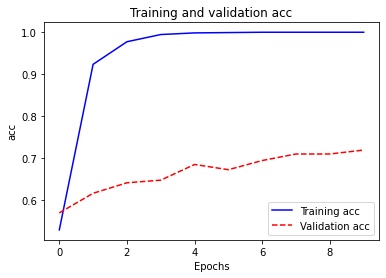

In [15]:
plot_results(history, 'acc')

In [16]:
score = model.evaluate(X_test, y_test)
print(f'#Test accuracy: {score[1]:.3f}')

13/13 [==============================] - 0s 3ms/step - loss: 0.5605 - acc: 0.7225
#Test accuracy: 0.723


## 2) RNN 기반

### RNN

In [17]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam

In [18]:
model = Sequential([
    Embedding(max_words, 32),
    SimpleRNN(32),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 323,169
Trainable params: 323,169
Non-trainable params: 0
_________________________________________________________________


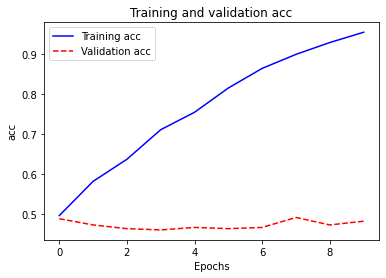

13/13 [==============================] - 1s 38ms/step - loss: 0.6973 - acc: 0.5325
#Test accuracy:0.533


In [20]:
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, 
                    epochs=10,
                    verbose=0,
                    validation_split=0.2)

plot_results(history, 'acc')

score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

### LSTM

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714,369
Trainable params: 714,369
Non-trainable params: 0
_________________________________________________________________


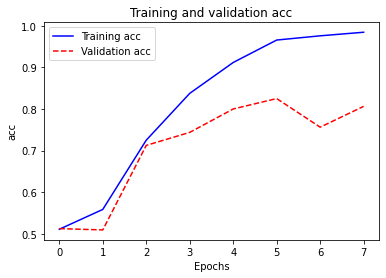

13/13 [==============================] - 1s 15ms/step - loss: 0.4605 - acc: 0.7975
#Test accuracy:0.798


In [21]:
from tensorflow.keras.layers import LSTM, Bidirectional

model = Sequential([
    Embedding(max_words, 64),
    Bidirectional(LSTM(64)), 
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=8,
                    verbose=0,
                    validation_split=0.2)

plot_results(history, 'acc')


score = model.evaluate(X_test, y_test)
print(f'#Test accuracy:{score[1]:.3f}')

In [22]:
y_pred = np.round(model.predict(X_test[:10]))
for pred, y_t in zip(y_pred, y_test[:10]):
    print(f'predicted value: {pred[0]}, true value: {y_t}, so the prediction is {pred[0] == y_t}')

predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 0.0, true value: 1, so the prediction is False
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 0, so the prediction is False
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True
